# Cluster datapoints and visualize them
For each trajectory there is one datapoint with the averaged data, e.g., the average amount of water vapor, sensitivity, etc. \
Only the ascent and 2h before and after the ascent are considered. \
If the x-axis and y-axis are the same, a histogram is plotted.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=RuntimeWarning)

import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm.auto import tqdm
import xarray as xr

from scripts.latexify import param_id_map
from scripts.cluster_data import *

pn.extension()

## Using data from all phases

In [2]:
data = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/averaged_data.nc",
    decode_times=False,
    engine="netcdf4",
)
data

<xarray.Dataset>
Dimensions:                       (trajectory: 1113, file: 44, ensemble: 1,
                                   Output_Parameter_ID: 3)
Coordinates:
  * trajectory                    (trajectory) uint64 0 1 2 3 ... 1110 1111 1112
  * file                          (file) object 'Z2_wcb_trajs_20161003_19.nc'...
  * ensemble                      (ensemble) uint64 0
  * Output_Parameter_ID           (Output_Parameter_ID) uint64 6 22 23
Data variables: (12/207)
    pressure                      (file, ensemble, trajectory) float32 ...
    T                             (file, ensemble, trajectory) float32 ...
    w                             (file, ensemble, trajectory) float32 ...
    S                             (file, ensemble, trajectory) float32 ...
    QC                            (file, ensemble, trajectory) float32 ...
    QR                            (file, ensemble, trajectory) float32 ...
    ...                            ...
    time_after_ascent             (file, ensemble, trajectory) float32 ...
    asc600                        (file, ensemble, trajectory) float64 ...
    lat                           (file, ensemble, trajectory) float32 ...
    lon                           (file, ensemble, trajectory) float32 ...
    step                          (file, ensemble, trajectory) float64 ...
    phase                         (file, ensemble, trajectory) float64 ...
Attributes:
    time:     2016-10-03T19:00:00.000

In [3]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
verbose = True

In [4]:
clusters = get_cluster(
    data=data,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    verbose=verbose,
)

Calculate the cluster


Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
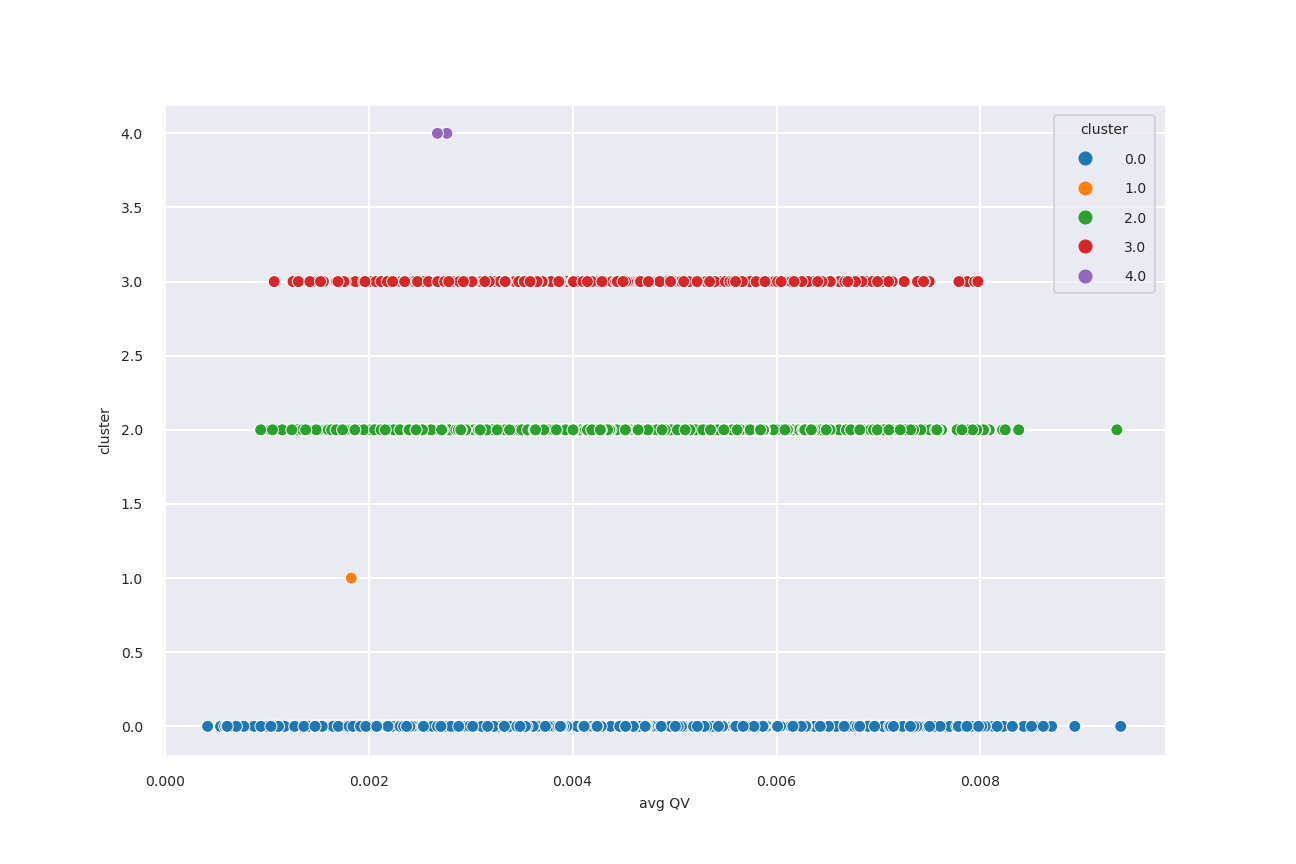

In [5]:
plot_cluster_data_interactive(clusters)

## Using data solely from the warm phase

In [2]:
data_warm = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/averaged_data_warm.nc",
    decode_times=False,
    engine="netcdf4",
)

In [3]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
verbose = True

In [4]:
clusters_warm = get_cluster(
    data=data_warm,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    verbose=verbose,
)

Calculate the cluster


Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
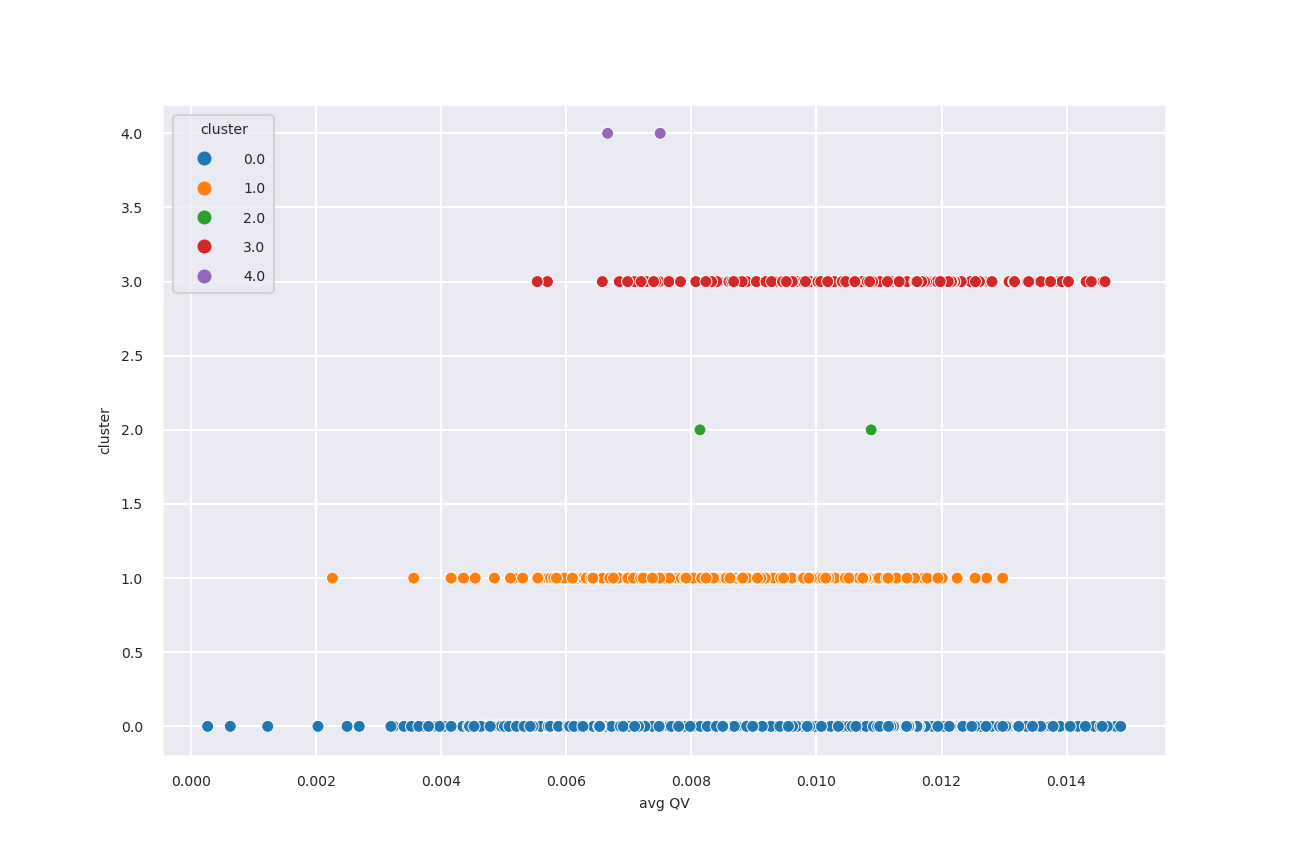

In [5]:
plot_cluster_data_interactive(clusters_warm)

## Using data solely from the mixed phase

In [10]:
data_mixed = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/averaged_data_mixed.nc",
    decode_times=False,
    engine="netcdf4",
)

In [11]:
# The amount of clusters
k = 5
# Sensitivities for the following model states are considered
sens_model_states = ["QV", "latent_heat", "latent_cool"]
# Use the following parameters for clustering
cluster_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool',
]
verbose = True

In [12]:
clusters_mixed = get_cluster(
    data=data_mixed,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    verbose=verbose,
)

Calculate the cluster


Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
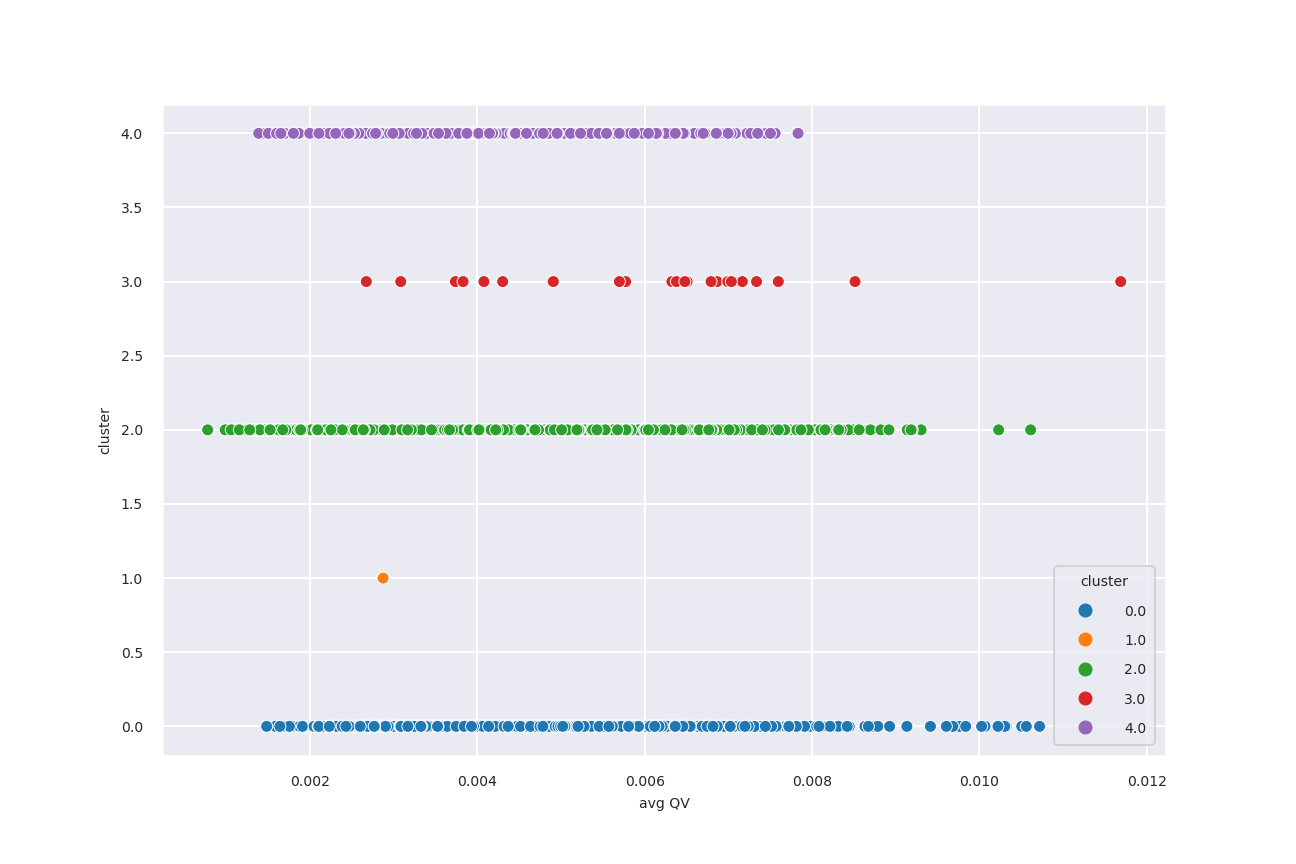

In [13]:
plot_cluster_data_interactive(clusters_mixed)

## Mixed phase but only clustering for w

In [2]:
data_mixed = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/averaged_data_mixed.nc",
    decode_times=False,
    engine="netcdf4",
)
# The amount of clusters
k = 5
# Model states to define the sensitivities are not needed here
# because we only cluster using w
sens_model_states = None
# Here we list all variables that we want to plot including the
# variables that we use for clustering
plot_var = [
    'da_prime', 'dk_1_conv', 'dcloud_max_x', 'dT_mult_min', 'dgraupel_b_vel', 
    'dhande_ccn_fac', 'drain_cmu3', 'dp_sat_melt', 'dkc_autocon', 'dk_r', 
    'drain_mu', 'db_v', 'drain_a_geo', 'dgraupel_a_geo', 'dk_2_conv', 
    'drain_b_geo', 'dice_b_geo', 'db_prime', 'dsnow_b_geo', 'drain_b_vel', 
    'dg_ccn_1', 'dg_ccn_2', 'dh_ccn_1', 'dc_prime', 'di_ccn_1', 'dgraupel_b_geo', 
    'dice_a_geo', 'dice_b_vel', 'dkin_visc_air', 'drain_nu', 'da_HET', 'da_v',
    'w', 'QV', 'latent_heat', 'latent_cool', "lon", "lat", "time_after_ascent",
]
# Use the following parameter for clustering; either a string or a list is fine
cluster_var = 'w'
verbose = True
# Return all columns and not just the ones used for clustering
include_all_data = True
# remove some columns such that we have fewer to select during visualisation
data_mixed = data_mixed[plot_var]

In [3]:
clusters_mixed = get_cluster(
    data=data_mixed,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    include_all_data=include_all_data,
    verbose=verbose,
)

Calculate the cluster


  0%|          | 0/43 [00:00<?, ?it/s]

Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='QV')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['QV', 'latent_cool', ...], value='QV')
        [1] Select(name='Model parameter o..., options=['QV', 'cluster', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
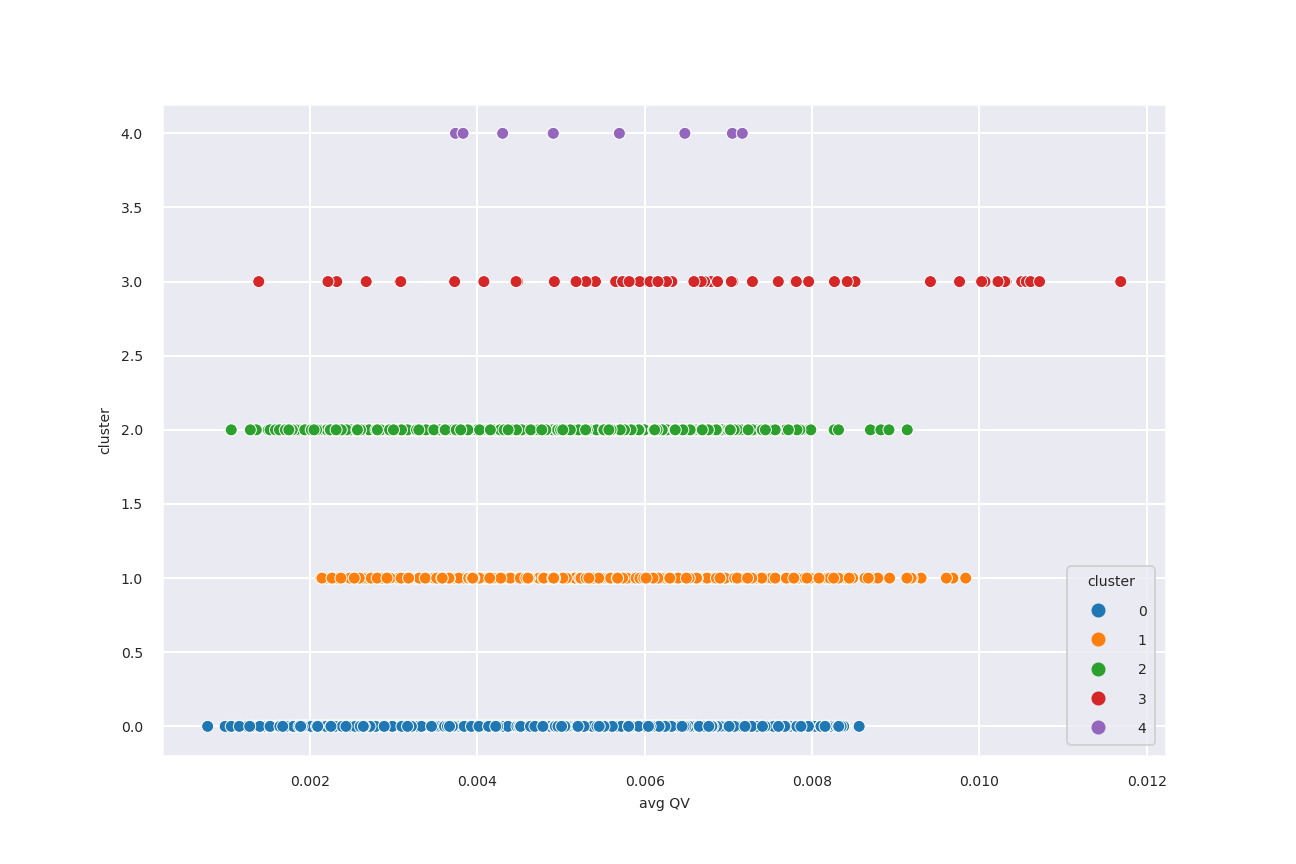

In [4]:
plot_cluster_data_interactive(clusters_mixed)

## Using data solely from the ice phase

In [17]:
data_ice = xr.open_dataset(
    "/media/mahieron/Austausch/data/Z2_data_stats/averaged_data_ice.nc",
    decode_times=False,
    engine="netcdf4",
)

In [18]:
clusters_ice = get_cluster(
    data=data_ice,
    k=k,
    x=cluster_var,
    param_names=sens_model_states,
    verbose=verbose,
)

Calculate the cluster


  0%|          | 0/43 [00:00<?, ?it/s]

Column
    [0] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['Not available'], value='Not available')
        [1] Select(name='Model parameter o..., options=['cluster', 'file', ...], value='cluster')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [1] Row
        [0] RadioButtonGroup(button_type='primary', name='Output Parameter (..., options=['Not available'], value='Not available')
        [1] Select(name='Model parameter o..., options=['cluster', 'file', ...], value='file')
        [2] Toggle(button_type='success', name='Use log-scale f...)
    [2] Row
        [0] IntSlider(end=15, name='Width in inches', start=3, value=9)
        [1] IntSlider(end=15, name='Height in inches', start=3, value=6)
        [2] FloatSlider(end=2, name='Scale fontsize', start=0.2, value=0.7)
    [3] Row
        [0] TextInput(value='Path/to/store/plot.png')
        [1] Button(button_type='primary', name='Save Plot')
    [4] TextInput(name='Title')
    [5] ParamFunction(function)
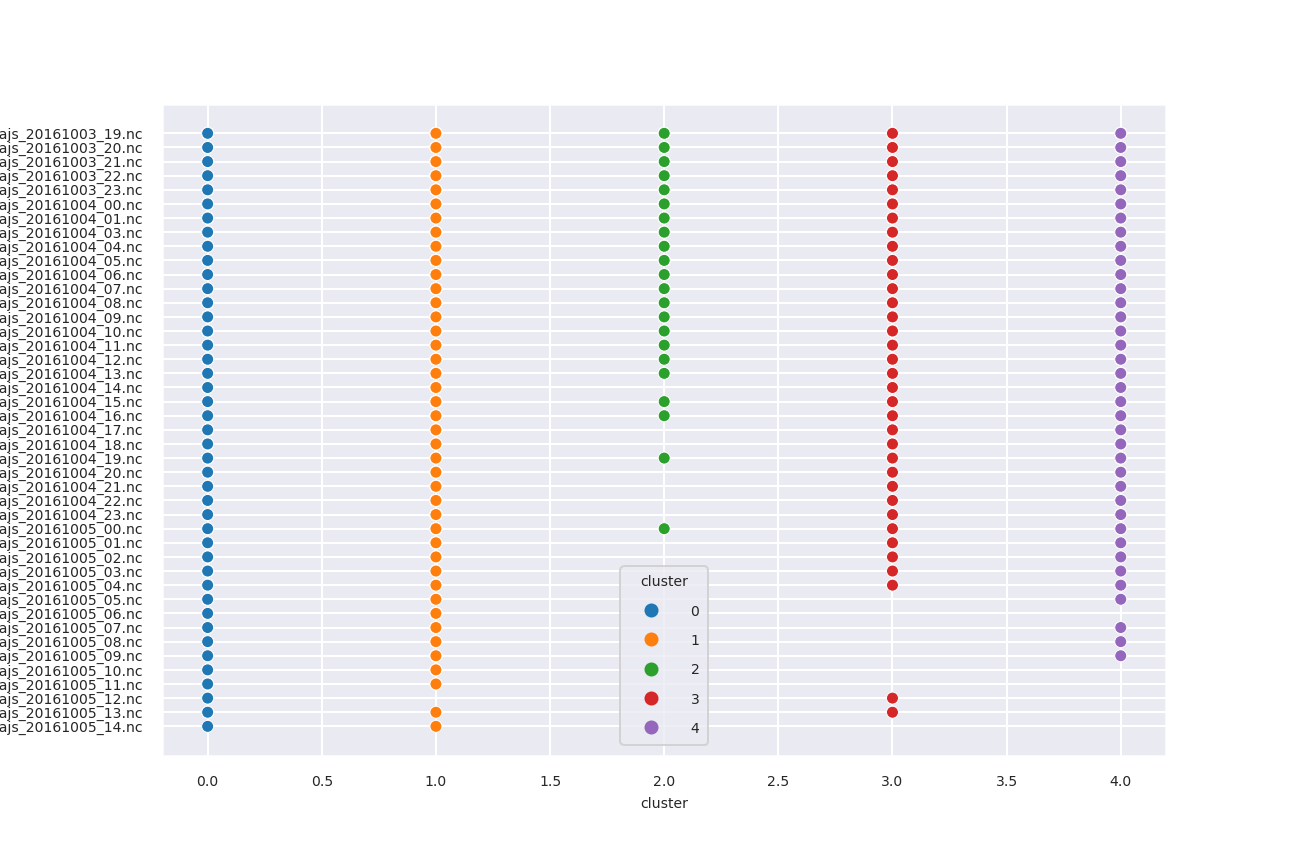

In [19]:
plot_cluster_data_interactive(clusters_ice)